<a href="https://colab.research.google.com/github/ethansong206/Climate-Plus-Project/blob/main/DataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
#@title Import packages
import pandas as pd
import numpy as np
from datetime import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from matplotlib.patches import ConnectionPatch
import matplotlib.patches as mpatches
import calendar
import matplotlib.cm as cm

In [179]:
#@title Load csv and clean locations + dates
DiningDataFull = pd.read_csv('/content/drive/MyDrive/Data+/Climate+ Data 2019 thru 2023.csv',
                             dtype = {'Priority 1': str, 'Priority 2': str,
                                      'Priority 3': str})
#print(DiningDataFull['Unit Name'].value_counts()) # Show how many entries there are of each location

#below code to make 'Unit Name' column easier to handle
#can add more lines given more locations
def location_rename(location):
    if("Marketplace" in location): #Combine data for Marketplace Kitchen and Marketplace Special Event
        return "Marketplace"
    if("Marine Lab" in location):
        return "DuML"
    if("Trinity" in location):
        return "Trinity"
    if("Freeman" in location):
        return "Freeman"
    return None

DiningDataFull['Unit Name'] = DiningDataFull.apply(lambda d: location_rename(d['Unit Name']), axis = 1)

DiningDataFull['Purchase Date'] = DiningDataFull.apply(lambda d: datetime.strptime(d['Purchase Date'], '%m/%d/%Y').date(), axis = 1)

print("Rows in DiningDataFull: ", DiningDataFull.shape[0])

Rows in DiningDataFull:  92166


---
Extract the unit names for each item into a new column called `Unit`, then rename each unit into a more simple label (i.e. LB CS to LB). Convert cans and bottle cases into the equivalent value in OZ.

Extract the simplified item name from `Vendor Item Description` into a new column called `Item Name`.

---
Note on Exclusion: Some units are left out in this first calculation of emissions as they are either not directly food (i.e. gloves) or are too difficult to go through individually and find a measurement that is not ambiguous. The total number of entries left out is 12171. **The number of non-food items in this amount can be calculated later.**

---
Note on Conversions: The column `Vendor Item Purchase Unit` is in the format x/y n which should be read as x bags of y units of n food.

---

In [180]:
#@title Extract and clean units and item names
#this code extracts just the unit information
DiningDataFull['Unit'] = DiningDataFull['Vendor Item Purchase Unit'].str.extract(r" ?([A-Za-zÀ-ÿ ]*)$").astype(str)
#below code to simplify redundant labels (i.e. LB CS to LB)
#first, make it all uppercase to simplify code
DiningDataFull['Unit'] = DiningDataFull['Unit'].str.upper()
def unit_rename(unit):
    if('LB' in unit) | ('POUND' in unit):
        return 'LB'
    if('OZ' in unit) | (' Z' in unit):
        return 'OZ'
    if('GA' in unit) | ('GAL' in unit):
        return 'GA'
    if('QT' in unit):
        return 'QT'
    if('PT' in unit) | ('PINT' in unit):
        return 'PT'
    if('LT' in unit):
        return 'LT'
    if('BU' in unit) | ('Bushel' in unit): #bushels
        return 'BU'
    if('KG' in unit):
        return 'KG'
    if('GR' in unit): #grams
        return 'GR'
    if('ML' in unit): #milliliters
        return 'ML'
    if('CN' in unit) | ('Can' in unit):
        return 'CN'
    if('BOTTLE CASE' in unit):
        return 'Bottle Case'
    return None
#Notes: Bottle Case is 64 oz each, find # of can and translate to oz, anything with EA is not included for now (~9000)
DiningDataFull['Unit'] = DiningDataFull.apply(lambda d: unit_rename(d['Unit']), axis = 1)

#convert cans to OZ
#using estimates for weight of cans through https://food.unl.edu/article/how-interpret-can-size-numbers
DiningDataFull = DiningDataFull.replace({'#10 CN' : '110.5 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'#10 Can' : '110.5 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'#300 CN' : '15 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'CN' : 'OZ'})

#convert bottle case to OZ
DiningDataFull = DiningDataFull.replace({' Bottle Case' : '/64 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'BOTTLE CASE' : 'OZ'})

#extract clean item names
#make everything uppercase and remove zz's in front of some of the item descriptions
DiningDataFull['Vendor Item Description'] = DiningDataFull['Vendor Item Description'].str.upper()
DiningDataFull['Vendor Item Description'] = DiningDataFull['Vendor Item Description'].apply(lambda x: re.sub(r'^ZZ ', '', x))
DiningDataFull['Vendor Item'] = DiningDataFull['Vendor Item Description'].str.extract(r'(.*),')
DiningDataFull['Vendor Item'] = DiningDataFull['Vendor Item'].str.upper()

print(DiningDataFull.head())

     Unit Name    Vendor Purchase Date Vendor Item ID  \
0  Marketplace  US Foods    2019-07-01        5018999   
1  Marketplace  US Foods    2019-07-01        5400692   
2  Marketplace  US Foods    2019-07-01        8012643   
3  Marketplace  US Foods    2019-07-01         731349   
4  Marketplace  US Foods    2019-07-01          68106   

                             Vendor Item Description  \
0  POTATO, FRENCH-FRY 3/4 X3/8 STEAK CUT SKIN-ON ...   
1  POTATO, FRENCH-FRY SPIRAL COATED SEASONED TFF ...   
2  POTATO, FRENCH-FRY 1/2 CRINKLE-CUT TFF EXTRA-L...   
3                POTATO, HASH BROWN SHRED COOKED REF   
4    POTATO, TATER NUGGET PARFRIED FROZEN HASH BROWN   

  Vendor Item Purchase Unit                              Product Group  \
0                    6/5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
1                    6/5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
2                  6/4.5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
3                   2/10

---
Make a new column called `Total Amount` for the total amount of food in the current unit of measurement, before converting to grams. Make a new column called `Total Amount(g)` for converting all units to the equivalent value in grams, then filter out main descriptor word(s) in `Vendor Item Description` into a new column called `Food Name`.

---

Take the column with units in grams and multiply by the `Receive Quantity` if provided into a new column called `Total Grams`. If there is no value in `Receive Quantity`, then assume it is the value 1.

---
Note on Conversions: Most of these conversions are estimated to the nearest tenth. **More accurate calculations can be found later**

---

In [181]:
#@title DDReduced and DDReducedLabeled
#make a new dataset for just entries with known units
DDReduced = DiningDataFull[DiningDataFull['Unit'].notna()]
#print(DDReduced.head())

#make csv to manually edit unclean entries
#DDReduced.to_csv('DDReduced.csv', encoding = 'utf-8-sig')
#files.download('DDReduced.csv')

DDReducedLabeled = pd.read_csv('/content/drive/MyDrive/Data+/DDReducedLabeled.csv')

DDReducedLabeled['Purchase Date'] = DDReducedLabeled.apply(lambda d: datetime.strptime(d['Purchase Date'], '%m/%d/%Y').date(), axis = 1)

print(DDReduced.head())

<ipython-input-181-b935d8133d80>:10: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  DDReducedLabeled = pd.read_csv('/content/drive/MyDrive/Data+/DDReducedLabeled.csv')


     Unit Name    Vendor Purchase Date Vendor Item ID  \
0  Marketplace  US Foods    2019-07-01        5018999   
1  Marketplace  US Foods    2019-07-01        5400692   
2  Marketplace  US Foods    2019-07-01        8012643   
3  Marketplace  US Foods    2019-07-01         731349   
4  Marketplace  US Foods    2019-07-01          68106   

                             Vendor Item Description  \
0  POTATO, FRENCH-FRY 3/4 X3/8 STEAK CUT SKIN-ON ...   
1  POTATO, FRENCH-FRY SPIRAL COATED SEASONED TFF ...   
2  POTATO, FRENCH-FRY 1/2 CRINKLE-CUT TFF EXTRA-L...   
3                POTATO, HASH BROWN SHRED COOKED REF   
4    POTATO, TATER NUGGET PARFRIED FROZEN HASH BROWN   

  Vendor Item Purchase Unit                              Product Group  \
0                    6/5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
1                    6/5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
2                  6/4.5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
3                   2/10

In [182]:
#@title Find total amount of food
#find total amount of food in original unit before converting to grams
DDReduced = DDReduced.copy()
DDReduced['Total Amount'] = DDReduced['Vendor Item Purchase Unit'].str.extract(r'^[a-zA-Z]* ?-?/? ?([0-9]*/?[0-9.]*-?[0-9.]*)')
DDReduced['Range'] = DDReduced['Total Amount'].str.extract(r'([0-9.]*-[0-9.]*)')
DDReduced['Range'] = DDReduced['Range'].astype(str)
DDReduced['Range'] = DDReduced['Range'].replace({'nan' : '0'})
DDReduced['Range Average'] = DDReduced['Range'].replace({'-' : '+'}, regex = True)
DDReduced['Range Average'] = DDReduced.apply(lambda d: eval(d['Range Average']), axis = 1)
DDReduced['Range Average'] /= 2

has_slash = ~(DDReduced['Total Amount'].str.contains('/')) & (DDReduced['Total Amount'].str.len() > 0)
DDReduced.loc[has_slash, 'Total Amount'] = (
    '1/' + DDReduced.loc[has_slash, 'Total Amount']
)

has_range = DDReduced['Total Amount'].str.contains('-')
DDReduced.loc[has_range, 'Total Amount'] = (
    DDReduced.loc[has_range, 'Total Amount'].str.split('/').str[0]
    + '/'
    + DDReduced.loc[has_range, 'Range Average'].astype(str)
)

just_unit = (DDReduced['Total Amount'] == '') & ~(DDReduced['Vendor Item Purchase Unit'].isna())
DDReduced.loc[just_unit, 'Total Amount'] = '1'

DDReduced = DDReduced.drop(['Range', 'Range Average'], axis = 1)

DDReduced['Total Amount'] = DDReduced['Total Amount'].replace({'' : '0'})
DDReduced['Receive Quantity'] = DDReduced['Receive Quantity'].fillna(0)
DDReduced = DDReduced[DDReduced['Receive Quantity'] != 0] #get rid of any rows that were not received
DDReduced['Total Amount'] = DDReduced['Total Amount'].replace({'/' : '*'}, regex = True)
DDReduced['Total Amount'] = DDReduced.apply(lambda d: eval(d['Total Amount']), axis = 1)
DDReduced['Total Amount'] = DDReduced['Total Amount'].astype(float) * DDReduced['Receive Quantity'].astype(float)

RQ_whole_number = DDReduced['Receive Quantity'] % 1 == 0
DDReduced.loc[~RQ_whole_number, 'Total Amount'] = DDReduced.loc[~RQ_whole_number, 'Receive Quantity']

purchase_too_large = (DDReduced['Total Amount'] > 1000) & (DDReduced['Unit'] == 'LB')
DDReduced.loc[purchase_too_large, 'Total Amount'] = DDReduced.loc[purchase_too_large, 'Receive Quantity']

print(DDReduced.head())

     Unit Name    Vendor Purchase Date Vendor Item ID  \
0  Marketplace  US Foods    2019-07-01        5018999   
1  Marketplace  US Foods    2019-07-01        5400692   
2  Marketplace  US Foods    2019-07-01        8012643   
3  Marketplace  US Foods    2019-07-01         731349   
4  Marketplace  US Foods    2019-07-01          68106   

                             Vendor Item Description  \
0  POTATO, FRENCH-FRY 3/4 X3/8 STEAK CUT SKIN-ON ...   
1  POTATO, FRENCH-FRY SPIRAL COATED SEASONED TFF ...   
2  POTATO, FRENCH-FRY 1/2 CRINKLE-CUT TFF EXTRA-L...   
3                POTATO, HASH BROWN SHRED COOKED REF   
4    POTATO, TATER NUGGET PARFRIED FROZEN HASH BROWN   

  Vendor Item Purchase Unit                              Product Group  \
0                    6/5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
1                    6/5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
2                  6/4.5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
3                   2/10

In [183]:
#@title Convert all units to kilograms
def convert_units(row):
    if row['Unit'] == 'LB':
        return row['Total Amount'] * 453.6
    if row['Unit'] == 'OZ':
        return row['Total Amount'] * 28.35
    if row['Unit'] == 'GA':
        return row['Total Amount'] * 3785.4 #assuming density of water, most drinks are MORE dense so number is underestimate
    if row['Unit'] == 'QT':
        return row['Total Amount'] * 3785.4 / 4
    if row['Unit'] == 'PT':
        return row['Total Amount'] * 3785.4 / 8
    if (row['Unit'] == 'LT') | (row['Unit'] == 'KG'):
        return row['Total Amount'] * 1000 #also assuming density of water, most drinks MORE dense
    if (row['Unit'] == 'ML') | (row['Unit'] == 'GR'):
        return row['Total Amount']
    return 0
DDReduced['Total Amount(kg)'] = DDReduced.apply(convert_units, axis = 1) / 1000

#modify `Product Group` column
DDReduced = DDReduced[DDReduced['Product Group'].notna()]
DDReduced['Product Group'] = DDReduced['Product Group'].str.upper() #make uppercase to simplify code

In [184]:
#@title Excluded rows
print("Excluded rows: ", DiningDataFull.shape[0] - DDReduced.shape[0])
#print(DDReduced.head())

Excluded rows:  17304


---
#NLP

Come back later and try this, too difficult for now
---

In [185]:
#@title NLP packages
# from google.colab import files
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.preprocessing import LabelEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

In [186]:
#@title NLP labeled data
#Create training set with ~10000 random entries
#DDtest = DDReduced.sample(10000)
#DDtest.to_csv('DDtest.csv', encoding = 'utf-8-sig')
#files.download('DDtest.csv')

# DDLabeled = pd.read_csv('DDLabeled.csv')

# print(DDLabeled.head())

#Notes on labels:
#syrup is 2/3 sugar 1/3 water for emissions
#many vegetables are labeled "Leafy greens" for now
#smoothies are labeled smoothie for now, can find fruits in each or average smoothie emissions later
#mushrooms need emissions numbers
#fruit is used to label misc less-common fruits
#avocados need emission numbers
#dressings need emission numbers
#squashes need emission numbers

In [187]:
#@title NLP model
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from sklearn.preprocessing import LabelEncoder

# # Preprocess the data
# text_data = DDLabeled['Vendor Item Description']
# labels = DDLabeled['Product Group']

# # Label encode the target variable
# label_encoder = LabelEncoder()
# labels = label_encoder.fit_transform(labels)

# # Tokenize the text data
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(text_data)
# vocab_size = len(tokenizer.word_index) + 1

# # Convert text to sequences
# sequences = tokenizer.texts_to_sequences(text_data)

# # Pad sequences to have equal length
# max_sequence_length = max(len(seq) for seq in sequences)
# padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# # Split the data into training and testing sets
# train_size = int(0.8 * len(padded_sequences))
# train_text = padded_sequences[:train_size]
# train_labels = labels[:train_size]
# test_text = padded_sequences[train_size:]
# test_labels = labels[train_size:]

# # Define the neural network architecture
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, 100, input_length=max_sequence_length),
#     tf.keras.layers.LSTM(64),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
# ])

# # Compile the model
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# model.fit(train_text, train_labels, epochs=20, batch_size=32, validation_data=(test_text, test_labels))

In [188]:
#@title NLP testing
# # Evaluate the model
# loss, accuracy = model.evaluate(test_text, test_labels)
# print('Test Loss:', loss)
# print('Test Accuracy:', accuracy)

# # Make predictions on new data
# new_text = ['BEET, WHOLE PEELED COOKED 17.6 OZ VACUUM-PACK REF', 'BEIGELS CHALLAH']
# new_sequences = tokenizer.texts_to_sequences(new_text)
# new_padded_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
# predictions = model.predict(new_padded_sequences)
# predicted_labels = label_encoder.inverse_transform(tf.argmax(predictions, axis=1))
# print('Predicted Labels:', predicted_labels)

In [189]:
#@title Copy manually labeled data
#last time manually labeled was 6/21/23
DDReduced = pd.merge(DDReduced, DDReducedLabeled[['Index', 'Vendor Item']], left_index=True, right_on = 'Index', how = 'left')
DDReduced.rename(columns={'Vendor Item_y': 'Vendor Item'}, inplace=True)
DDReduced.drop('Vendor Item_x', axis=1, inplace=True)

In [190]:
#@title Remove Jan-Mar 2022 Dupes
start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2022-03-31')

filtered_df = DDReduced[(DDReduced['Purchase Date'] >= start_date) & (DDReduced['Purchase Date'] <= end_date)]
filtered_df = filtered_df.sort_values('Vendor Item Description')
filtered_df = filtered_df.iloc[::2]

DDReduced = pd.concat([DDReduced[~((DDReduced['Purchase Date'] >= start_date) & (DDReduced['Purchase Date'] <= end_date))], filtered_df])

<ipython-input-190-96a1bc4f9155>:5: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  filtered_df = DDReduced[(DDReduced['Purchase Date'] >= start_date) & (DDReduced['Purchase Date'] <= end_date)]
<ipython-input-190-96a1bc4f9155>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  DDReduced = pd.concat([DDReduced[~((DDReduced['Purchase Date'] >= start_date) & (DDReduced['Purchase Date'] <= end_date))], filtered_df])


In [191]:
#@title Explore labeled data
#print(DDReduced['Vendor Item_x'].value_counts()[50:100])
#print(DDReduced['Vendor Item Grouped'].value_counts()[:50])

In [192]:
#@title Item name cleaning
DDReduced['Vendor Item Grouped'] = DDReduced['Vendor Item']

def group_items(item):
    if(item == 'POTATO') | (item == 'CARROT') | (item == 'ONION') | \
      (item == 'SWEET POTATO') | (item == 'GARLIC') | (item == 'BEET') | \
      (item == 'TURNIP') | (item == 'YUCCA') | (item == 'RADISH') | \
      (item == 'SWEET POTATO PIE') | (item == 'POTATO SALAD') | \
      (item == 'SHALLOT') | (item == 'HORSERADISH') | (item == 'JICAMA') | \
      (item == 'RUTABAGA') | (item == 'SAMOSA') | (item == 'POTATO STARCH') | \
      (item == 'LATKE') | (item == 'CHIP'):
        return 'ROOT VEGETABLE'

    if(item == 'CEREAL') | (item == 'FLOUR') | (item == 'CORN STARCH') | \
      (item == 'QUINOA') | (item == 'CORNMEAL') | (item == 'BARLEY') | \
      (item == 'SUNFLOWER SEED') | (item == 'YEAST') | (item == 'CRACKER') | \
      (item == 'FARRO') | (item == 'PUMPKIN SEED') | (item == 'WHEAT') | \
      (item == 'FLAX') | (item == 'CHIA SEED') | (item == 'SNACK BAR') | \
      (item == 'GRITS'):
        return 'GRAIN'

    if(item == 'MUFFIN') | (item == 'CAKE') | (item == 'BAGEL') | \
      (item == 'CROISSANT') | (item == 'BISCUIT') | (item == 'DONUT') | \
      (item == 'DANISH') | (item == 'PANCAKE') | (item == 'HUSH PUPPY') | \
      (item == 'WAFFLE') | (item == 'BREADER') | (item == 'SCONE') | \
      (item == 'PIE CRUST') | (item == 'STUFFING') | (item == 'CROUTON') | \
      (item == 'CORNBREAD') | (item == 'CHURRO') | (item == 'DOUGH') | \
      (item == 'BABKA') | (item == 'MATZO') | (item == 'DESSERT BAR') | \
      (item == 'SANDWICH') | (item == 'PRETZEL') | (item == 'RUGALACH') | \
      (item == 'BOUREKAS') | (item == 'CHEESE PIZZA') | (item == 'BUN') | \
      (item == 'BOSTOM CREAM PIE') | (item == 'COOKIE'):
        return 'BREAD'

    if(item == 'TOMATO') | (item == 'STRAWBERRY') | (item == 'APPLE') | \
      (item == 'BANANA') | (item == 'ORANGE') | (item == 'GRAPEFRUIT') | \
      (item == 'BLUEBERRY') | (item == 'MANGO') | (item == 'FRUIT MIX') | \
      (item == 'STRAWBERRY BANANA') | (item == 'STRAWBERRY PIE') | \
      (item == 'CRANBERRY') | (item == 'PEACH') | (item == 'ORANGE MANGO') | \
      (item == 'BERRY MIX') | (item == 'LIME') | (item == 'PLANTAIN') | \
      (item == 'APPLE PIE') | (item == 'ORANGE PEACH') | (item == 'AVOCADO') | \
      (item == 'LEMON') | (item == 'LIME PIE') | (item == 'CHERRY PIE') | \
      (item == 'APRICOT') | (item == 'COCONUT') | (item == 'BLACKBERRY') | \
      (item == 'STRAWBERRY KIWI') | (item == 'RASPBERRY') | (item == 'PEAR') | \
      (item == 'BANANA PUDDING') | (item == 'PEACH PIE') | \
      (item == 'BLUEBERRY PIE') | (item == 'CHERRY') | (item == 'FIG') | \
      (item == 'RAISIN') | (item == 'LEMON LIME') | (item == 'PINEAPPLE') | \
      (item == 'LEMON PIE') | (item == 'PUMPKIN PIE') | (item == 'GRAPE') | \
      (item == 'WATERMELON') | (item == 'CHUTNEY') | (item == 'DATE') | \
      (item == 'POMEGRANATE') | (item == 'BANANA PIE') | (item == 'KIWI') | \
      (item == 'APPLE CIDER') | (item == 'BLUEBERRY POMEGRANATE') | \
      (item == 'STAR FRUIT') | (item == 'FRUIT PUNCH') | \
      (item == 'CHAROSET') | (item == 'PAPAYA'):
        return 'FRUIT'

    if(item == 'SEASONING') | (item == 'BASIL') | (item == 'PARSLEY') | \
      (item == 'CILANTRO') | (item == 'SALT') | (item == 'GINGER') | \
      (item == 'FLAVORING') | (item == 'THYME') | (item == 'ROSEMARY') | \
      (item == 'MINT') | (item == 'MUSTARD GREENS') | (item == 'CHIVE') | \
      (item == 'SAGE') | (item == 'OREGANO') | (item == 'LEMONGRASS') | \
      (item == 'PARSNIP') | (item == 'TARRAGON') | (item == 'FENNEL') | \
      (item == 'CURRY BASE'):
        return 'SPICES'

    if(item == 'SAUCE') | (item == 'DRESSING') | (item == 'MAYONNAISE') | \
      (item == 'KETCHUP') | (item == 'SPREAD') | (item == 'TOPPING') | \
      (item == 'SALSA') | (item == 'MUSTARD') | (item == 'JAM'):
        return 'CONDIMENTS'

    if(item == 'LETTUCE') | (item == 'BELL PEPPER') | (item == 'BROCCOLI') | \
      (item == 'VEGETABLE MIX') | (item == 'CORN') | (item == 'SQUASH') | \
      (item == 'ZUCCHINI') | (item == 'SPINACH') | (item == 'ASPARAGUS') | \
      (item == 'CUCUMBER') | (item == 'CAULIFLOWER') | (item == 'CABBAGE') | \
      (item == 'BOK CHOY') | (item == 'PICKLE') | (item == 'JALAPENO') | \
      (item == 'LASAGNA (VEGGIE)') | (item == 'BRUSSEL SPROUT') | \
      (item == 'JALAPENO PEPPER') | (item == 'COLLARD GREENS') | \
      (item == 'OKRA') | (item == 'BANANA PEPPER') | (item == 'EGGPLANT') | \
      (item == 'ARTICHOKE') | (item == 'CHILI PEPPER') | (item == 'RELISH') | \
      (item == 'CHIPOTLE PEPPER') | (item == 'COLESLAW') | (item == 'KALE') | \
      (item == 'WATER CHESTNUT') | (item == 'POBLANO PEPPER') | \
      (item == 'ARUGULA') | (item == 'SQUASH RAVIOLI') | (item == 'OLIVE') | \
      (item == 'CELERY') | (item == 'SPROUT') | (item == 'GOURD') | \
      (item == 'HEART OF PALM') | (item == 'POPCORN') | \
      (item == 'HABANERO PEPPER') | (item == 'SERRANO PEPPER') | \
      (item == 'THAI PEPPER') | (item == 'BEAN SPROUT') | \
      (item == 'TOMATILLO PEPPER') | (item == 'ENDIVE') | (item == 'BAMBOO') | \
      (item == 'PEPPERONCINI') | (item == 'SEAWEED') | (item == 'EGG ROLL') | \
      (item == 'SPRING ROLL'):
        return 'VEGETABLE'

    if(item == 'BEAN') | (item == 'HUMMUS') | (item == 'GREEN BEAN') | \
      (item == 'PEA') | (item == 'CHICKPEA') | (item == 'EDAMAME') | \
      (item == 'LENTIL') | (item == 'FALAFEL') | (item == 'PEANUT BUTTER') | \
      (item == 'CAPER') | (item == 'PECAN PIE'):
        return 'LEGUMES'

    if(item == 'CHICKEN') | (item == 'TURKEY') | (item == 'DUCK') | \
      (item == 'CHICKEN SALAD') | (item == 'CHICKEN TAMALE'):
        return 'POULTRY'

    if(item == 'SYRUP') | (item == 'HONEY') | (item == 'VANILLA EXTRACT') | \
      (item == 'MARSHMALLOW') | (item == 'ICING') | (item == 'CANDY') | \
      (item == 'POPSICLE') | (item == 'SPRINKLES') | (item == 'SHERBET') | \
      (item == 'SORBET') | (item == 'MOLASSES') | (item == 'GELATO') | \
      (item == 'CARAMEL SAUCE'):
        return 'SUGAR'

    if(item == 'BEEF SUB') | (item == 'CHICKEN SUB') | \
      (item == 'HOT DOG SUB'):
        return 'MEAT SUB'

    if(item == 'MILK SOY') | (item == 'MILK OAT') | (item == 'MILK COCONUT') | \
      (item == 'MILK ALMOND') | (item == 'MILK RICE'):
        return 'MILK SUB'

    if(item == 'HAM') | (item == 'CORN DOG') | (item == 'CHORIZO') | \
      (item == 'PEA SOUP W/ HAM'):
        return 'PORK'

    if(item == 'SHRIMP') | (item == 'SALMON') | (item == 'COD') | \
      (item == 'CATFISH') | (item == 'MAHI MAHI') | (item == 'FLOUNDER') | \
      (item == 'TUNA') | (item == 'CRAB') | (item == 'SCALLOP') | \
      (item == 'POLLOCK') | (item == 'GROUPER') | (item == 'LOBSTER') | \
      (item == 'MUSSEL') | (item == 'CLAM') | (item == 'SURIMI') | \
      (item == 'CLAM JUICE') | (item == 'TILAPIA') | (item == 'WHITING') | \
      (item == 'WHITEFISH') | (item == 'CROAKER') | (item == 'HADDOCK') | \
      (item == 'CRAWFISH'):
        return 'SEAFOOD'

    if(item == 'ICE CREAM') | (item == 'SOUR CREAM') | \
      (item == 'VANILLA PUDDING') | (item == 'PUDDING') | \
      (item == 'COOKIES & CREAM PIE') | (item == 'CHEESECAKE') | \
      (item == 'CREAMER'):
        return 'CREAM'

    if(item == 'NOODLE') | (item == 'MANICOTTI') | (item == 'PASTA SALAD') | \
      (item == 'TORTELLINI') | (item == 'MACARONI SALAD') | \
      (item == 'CHEESE RAVIOLI') | (item == 'FLORENTINE RAVIOLI'):
        return 'PASTA'

    if(item == 'PEPPERONI') | (item == 'SALAMI'):
        return 'SAUSAGE'

    if(item == 'CLEANING'):
        return 'NOT FOOD'

    if(item == 'MOUSSE') | (item == 'CHOCOLATE PIE') | (item == 'BROWNIE') | \
      (item == 'COCOA MIX') | (item == 'CHOCOLATE CAKE') | \
      (item == 'CHOCOLATE SAUCE'):
        return 'CHOCOLATE'

    if(item == 'LASAGNA (MEAT)') | (item == 'PASTRAMI') | (item == 'MEATBALL'):
        return 'BEEF'

    if(item == 'MUSHROOM RAVIOLI') | (item == 'MUSHROOM SOUP'):
        return 'MUSHROOM'

    if(item == 'MARGARINE'):
        return 'BUTTER'

    if(item == 'EGG SALAD'):
        return 'EGG'

    if(item == 'CRAB SOUP') | (item == 'CLAM SOUP') | (item == 'LOBSTER SOUP'):
        return 'SEAFOOD SOUP'

    if(item == 'CORN SOUP'):
        return 'VEGETABLE SOUP'

    if(item == 'CHEESE SAUCE'):
        return 'CHEESE'

    return item

def food_group(item):
    if(item == 'FRUIT') | (item == 'VEGETABLE') | (item == 'ROOT VEGETABLE') | \
      (item == 'OIL') | (item == 'LEGUMES') | (item == 'MUSHROOM') | \
      (item == 'VEGETABLE BASE') | (item == 'VEGETABLE SOUP') | \
      (item == 'MEAT SUB') | (item == 'TEMPEH') | (item == 'TOFU'):
        return 'FRUITS, VEGETABLES, AND SOY PRODUCTS'

    if(item == 'GRAIN') | (item == 'BREAD') | (item == 'PASTA') | \
      (item == 'RICE') | (item == 'CONDIMENTS') | (item == 'SPICES') | \
      (item == 'SUGAR') | (item == 'VINEGAR') | (item == 'SUGAR SUB'):
        return 'GRAINS, SPICES, AND CONDIMENTS'

    if(item == 'BEEF') | (item == 'PORK') | (item == 'EGG') | \
      (item == 'POULTRY') | (item == 'SEAFOOD') | (item == 'SEAFOOD SOUP') | \
      (item == 'SAUSAGE') | (item == 'CHICKEN BASE') | (item == 'BEEF BASE') | \
      (item == 'LAMB') | (item == 'GYRO MEAT') | (item == 'SEAFOOD BASE') | \
      (item == 'CHICKEN SOUP'):
        return 'MEATS'

    if(item == 'CREAM') | (item == 'BUTTER') | (item == 'MILK') | \
      (item == 'CHEESE') | (item == 'YOGURT') | (item == 'MILK SUB') | \
      (item == 'CHOCOLATE') | (item == 'CHEESE SUB') | (item == 'SODA') | \
      (item == 'COFFEE') | (item == 'WATER') | (item == 'WINE') | \
      (item == 'TEA BAG'):
        return 'DAIRY AND BEVERAGES'

DDReduced['Vendor Item Grouped'] = DDReduced.apply(lambda d: group_items(d['Vendor Item']), axis = 1)
DDReduced['Food Group'] = DDReduced.apply(lambda d: food_group(d['Vendor Item Grouped']), axis = 1)

In [193]:
#@title Load emissions csv and create emission ratio variables
#read csv here when done
#_______________________

#CURRENT VALUES: from Carbon Emissions Spreadsheet (6/30/23)
#er = emissions ratio
vegetable_er = 2
fruit_er = 1.1
bread_er = 1.5
root_vegetable_er = .5 #sarah bridle potato
condiments_er = 3.5
poultry_er = 5.05
cheese_er = 15.2 #sarah bridle
spices_er = .87
legumes_er = 1.8 #sarah bridle beans and pulses
grain_er = .226
pork_er = 10.2 #sarah bridle
beef_er = 43.7 #sarah bridle
#beef_er = 26.45 #heller
yogurt_er = 2.02
milk_er = 2.5 #sarah bridle
seafood_er = 13.6 #sarah bridle global
sugar_er = 2.055
oil_er = 3.16
mushroom_er = 2.54
cream_er = 3.77
pasta_er = 1.505
meat_sub_er = 2.19
egg_er = 3.7 #sarah bridle
milk_sub_er = .92
rice_er = 2.6 #sarah bridle
tofu_er = 2.1 #sarah bridle
chocolate_er = 4.56
water_er = .46
soda_er = .5 * sugar_er + .5 * water_er #change later
coffee_er = .5 #update later, unverified
butter_er = 11.92
sausage_er = .5 * beef_er + .5 * pork_er
vegetable_base_er = (1/68) * vegetable_er + (67/68) * water_er
wine_er = 1.1 #sarah bridle
vinegar_er = 2.24
tea_bag_er = 32.9
chicken_base_er = (1/68) * poultry_er + (67/68) * water_er
tempeh_er = .486
beef_base_er = (1/68) * beef_er + (67/68) * water_er
seafood_base_er = (1/68) * seafood_er + (67/68) * water_er
seafood_soup_er = .05 * seafood_er + .95 * seafood_base_er
cheese_sub_er = 7.6 #replace later, unverified
vegetable_soup_er = .05 * vegetable_er + .95 * vegetable_base_er
lamb_er = 39.7 #sarah bridle mutton & goat meat global
gyro_meat_er = .8 * beef_er + .2 * lamb_er
sugar_sub_er = .21
chicken_soup_er = .05 * poultry_er + .95 * chicken_base_er
#replace values with soft-coded values later

In [194]:
#@title Calculate Carbon Emissions
#only meats, meat alternatives, and eggs done so far
#print(DDReduced['Product Group'].value_counts())

def calc_emissions(row):
    if row['Vendor Item Grouped'] == 'VEGETABLE':
        return row['Total Amount(kg)'] * vegetable_er
    if row['Vendor Item Grouped'] == 'FRUIT':
        return row['Total Amount(kg)'] * fruit_er
    if row['Vendor Item Grouped'] == 'BREAD':
        return row['Total Amount(kg)'] * bread_er
    if row['Vendor Item Grouped'] == 'ROOT VEGETABLE':
        return row['Total Amount(kg)'] * root_vegetable_er
    if row['Vendor Item Grouped'] == 'CONDIMENTS':
        return row['Total Amount(kg)'] * condiments_er
    if (row['Vendor Item Grouped'] == 'POULTRY'):
        return row['Total Amount(kg)'] * poultry_er
    if row['Vendor Item Grouped'] == 'CHEESE':
        return row['Total Amount(kg)'] * cheese_er
    if row['Vendor Item Grouped'] == 'SPICES':
        return row['Total Amount(kg)'] * spices_er
    if row['Vendor Item Grouped'] == 'LEGUMES':
        return row['Total Amount(kg)'] * legumes_er
    if row['Vendor Item Grouped'] == 'GRAIN':
        return row['Total Amount(kg)'] * grain_er
    if row['Vendor Item Grouped'] == 'PORK':
        return row['Total Amount(kg)'] * pork_er
    if row['Vendor Item Grouped'] == 'BEEF':
        return row['Total Amount(kg)'] * beef_er
    if row['Vendor Item Grouped'] == 'YOGURT':
        return row['Total Amount(kg)'] * yogurt_er
    if row['Vendor Item Grouped'] == 'MILK':
        return row['Total Amount(kg)'] * milk_er
    if row['Vendor Item Grouped'] == 'SEAFOOD':
        return row['Total Amount(kg)'] * seafood_er
    if row['Vendor Item Grouped'] == 'SUGAR':
        return row['Total Amount(kg)'] * sugar_er
    if row['Vendor Item Grouped'] == 'OIL':
        return row['Total Amount(kg)'] * oil_er
    if row['Vendor Item Grouped'] == 'MUSHROOM':
        return row['Total Amount(kg)'] * mushroom_er
    if row['Vendor Item Grouped'] == 'CREAM':
        return row['Total Amount(kg)'] * cream_er
    if row['Vendor Item Grouped'] == 'PASTA':
        return row['Total Amount(kg)'] * pasta_er
    if row['Vendor Item Grouped'] == 'MEAT SUB':
        return row['Total Amount(kg)'] * meat_sub_er
    if row['Vendor Item Grouped'] == 'EGG':
        return row['Total Amount(kg)'] * egg_er
    if row['Vendor Item Grouped'] == 'MILK SUB':
        return row['Total Amount(kg)'] * milk_sub_er
    if row['Vendor Item Grouped'] == 'RICE':
        return row['Total Amount(kg)'] * rice_er
    if row['Vendor Item Grouped'] == 'TOFU':
        return row['Total Amount(kg)'] * tofu_er
    if row['Vendor Item Grouped'] == 'CHOCOLATE':
        return row['Total Amount(kg)'] * chocolate_er
    if row['Vendor Item Grouped'] == 'SODA':
        return row['Total Amount(kg)'] * soda_er
    if row['Vendor Item Grouped'] == 'COFFEE':
        return row['Total Amount(kg)'] * coffee_er
    if row['Vendor Item Grouped'] == 'WATER':
        return row['Total Amount(kg)'] * water_er
    if row['Vendor Item Grouped'] == 'SEAFOOD SOUP':
        return row['Total Amount(kg)'] * seafood_soup_er
    if row['Vendor Item Grouped'] == 'BUTTER':
        return row['Total Amount(kg)'] * butter_er
    if row['Vendor Item Grouped'] == 'SAUSAGE':
        return row['Total Amount(kg)'] * sausage_er
    if row['Vendor Item Grouped'] == 'VEGETABLE BASE':
        return row['Total Amount(kg)'] * vegetable_base_er
    if row['Vendor Item Grouped'] == 'WINE':
        return row['Total Amount(kg)'] * wine_er
    if row['Vendor Item Grouped'] == 'VINEGAR':
        return row['Total Amount(kg)'] * vinegar_er
    if row['Vendor Item Grouped'] == 'TEA BAG':
        return row['Total Amount(kg)'] * tea_bag_er
    if row['Vendor Item Grouped'] == 'CHICKEN BASE':
        return row['Total Amount(kg)'] * chicken_base_er
    if row['Vendor Item Grouped'] == 'TEMPEH':
        return row['Total Amount(kg)'] * tempeh_er
    if row['Vendor Item Grouped'] == 'BEEF BASE':
        return row['Total Amount(kg)'] * beef_base_er
    if row['Vendor Item Grouped'] == 'CHEESE SUB':
        return row['Total Amount(kg)'] * cheese_sub_er
    if row['Vendor Item Grouped'] == 'VEGETABLE SOUP':
        return row['Total Amount(kg)'] * vegetable_soup_er
    if row['Vendor Item Grouped'] == 'LAMB':
        return row['Total Amount(kg)'] *lamb_er
    if row['Vendor Item Grouped'] == 'GYRO MEAT':
        return row['Total Amount(kg)'] * gyro_meat_er
    if row['Vendor Item Grouped'] == 'SUGAR SUB':
        return row['Total Amount(kg)'] * sugar_sub_er
    if row['Vendor Item Grouped'] == 'SEAFOOD BASE':
        return row['Total Amount(kg)'] * seafood_base_er
    if row['Vendor Item Grouped'] == 'CHICKEN SOUP':
        return row['Total Amount(kg)'] * chicken_soup_er
    return 0

DDReduced['CO2e(kg)'] = DDReduced.apply(calc_emissions, axis = 1)

total_food_amount_kg = DDReduced[DDReduced['Total Amount(kg)'] != 0]['Total Amount(kg)'].sum()
total_food_amount_calced_kg = DDReduced[(DDReduced['Total Amount(kg)'] != 0) & (DDReduced['CO2e(kg)'] != 0)]['Total Amount(kg)'].sum()
percent_food_calced = total_food_amount_calced_kg / total_food_amount_kg * 100

print('The percentage of food (by weight) with calculated carbon emissions so far is: ', percent_food_calced, "%")

The percentage of food (by weight) with calculated carbon emissions so far is:  99.12155555576044 %


In [195]:
#@title Create separated dataframes
DDReduced['Purchase Date'] = pd.to_datetime(DDReduced['Purchase Date'])
DDReduced['Purchase Month'] = DDReduced['Purchase Date'].dt.month

location_col = DDReduced['Unit Name']
DDMarketplace = DDReduced[location_col == "Marketplace"].copy()
DDDuML = DDReduced[location_col == "DuML"].copy()
DDTrinity = DDReduced[location_col == "Trinity"].copy()
DDFreeman = DDReduced[location_col == "Freeman"].copy()

date_col = DDReduced['Purchase Date']
DDFY20 = DDReduced[(date_col >= pd.Timestamp('2019-07-01')) & (date_col < pd.Timestamp('2020-06-30'))].copy()
DDFY21 = DDReduced[(date_col >= pd.Timestamp('2020-07-01')) & (date_col < pd.Timestamp('2021-06-30'))].copy()
DDFY22 = DDReduced[(date_col >= pd.Timestamp('2021-07-01')) & (date_col < pd.Timestamp('2022-06-30'))].copy()
DDFY23 = DDReduced[(date_col >= pd.Timestamp('2022-07-01')) & (date_col < pd.Timestamp('2023-06-30'))].copy()

DDFY20['Fiscal Year'] = '2020'
DDFY21['Fiscal Year'] = '2021'
DDFY22['Fiscal Year'] = '2022'
DDFY23['Fiscal Year'] = '2023'

In [196]:
#@title Analysis
#later, download a csv from previous code and move this to a new notebook
total_food_emissions_2022 = DDFY22['CO2e(kg)'].sum()
total_duke_emissions_2022 = 194346000 #in kg, from 2022 GHG emissions

total_food_amount_kg_2022 = DDFY22['Total Amount(kg)'].sum()
total_food_amount_calced_kg_2022 = DDFY22[DDFY22['CO2e(kg)'] != 0]['Total Amount(kg)'].sum()
percent_food_calced_2022 = total_food_amount_calced_kg_2022 / total_food_amount_kg_2022 * 100

print('The percentage of food (by weight) with calculated carbon emissions so far in 2022 is: ', percent_food_calced_2022, "%")
print('')
print("Of what has been calculated, food is ", total_food_emissions_2022 / total_duke_emissions_2022 * 100, "% of Duke's total GHG emissions in 2022")
print("The value in Metric Tons is: ", total_food_emissions_2022 / 1000)
print("If food is not included in Duke's calculations, then the reported amount is: ", total_duke_emissions_2022 / (total_duke_emissions_2022 + total_food_emissions_2022) * 100, "% of the real total emissions")
print('')
print("Multiplying by a ratio of 33/4 to estimate all locations gets us", total_food_emissions_2022 * (33/4) / 1000, "Metric Tons of CO2eq.")
print("This would make the reported amount ", total_duke_emissions_2022 / (total_duke_emissions_2022 + total_food_emissions_2022 * (33/4)) * 100, "% of the real total emissions")

The percentage of food (by weight) with calculated carbon emissions so far in 2022 is:  99.16553858101393 %

Of what has been calculated, food is  1.1741366829294997 % of Duke's total GHG emissions in 2022
The value in Metric Tons is:  2281.8876778061654
If food is not included in Duke's calculations, then the reported amount is:  98.8394892989212 % of the real total emissions

Multiplying by a ratio of 33/4 to estimate all locations gets us 18825.573341900865 Metric Tons of CO2eq.
This would make the reported amount  91.16881625126115 % of the real total emissions


In [197]:
#@title Explore Food Emissions Breakdown
pc_fvs22 = DDFY22[DDFY22['Food Group'] == 'FRUITS, VEGETABLES, AND SOY PRODUCTS']['CO2e(kg)'].sum() / total_food_emissions_2022 * 100
pc_gsc22 = DDFY22[DDFY22['Food Group'] == 'GRAINS, SPICES, AND CONDIMENTS']['CO2e(kg)'].sum() / total_food_emissions_2022 * 100

pc_meat22 = DDFY22[DDFY22['Food Group'] == 'MEATS']['CO2e(kg)'].sum() / total_food_emissions_2022 * 100
pc_beef22 = DDFY22[(DDFY22['Vendor Item Grouped'] == 'BEEF') | \
                   (DDFY22['Vendor Item Grouped'] == 'BEEF BASE')]['CO2e(kg)'].sum() / total_food_emissions_2022 * 100
pc_pork22 = DDFY22[(DDFY22['Vendor Item Grouped'] == 'PORK') | \
                   (DDFY22['Vendor Item Grouped'] == 'SAUSAGE')]['CO2e(kg)'].sum() / total_food_emissions_2022 * 100
pc_poultry22 = DDFY22[(DDFY22['Vendor Item Grouped'] == 'POULTRY') | \
                      (DDFY22['Vendor Item Grouped'] == 'EGG') | \
                      (DDFY22['Vendor Item Grouped'] == 'CHICKEN SOUP') | \
                      (DDFY22['Vendor Item Grouped'] == 'CHICKEN BASE')]['CO2e(kg)'].sum() / total_food_emissions_2022 * 100
pc_seafood22 = DDFY22[(DDFY22['Vendor Item Grouped'] == 'SEAFOOD') | \
                      (DDFY22['Vendor Item Grouped'] == 'SEAFOOD SOUP') | \
                      (DDFY22['Vendor Item Grouped'] == 'SEAFOOD BASE')]['CO2e(kg)'].sum() / total_food_emissions_2022 * 100
pc_lamb22 = DDFY22[(DDFY22['Vendor Item Grouped'] == 'LAMB') | \
                   (DDFY22['Vendor Item Grouped'] == 'GYRO MEAT')]['CO2e(kg)'].sum() / total_food_emissions_2022 * 100

pc_db22 = DDFY22[DDFY22['Food Group'] == 'DAIRY AND BEVERAGES']['CO2e(kg)'].sum() / total_food_emissions_2022 * 100

print("Fruits, Vegetables, and Soy Products =", str.format('{0:.2f}', pc_fvs22), "%")
print("Grains, Spices, Condiments =", str.format('{0:.2f}', pc_gsc22), "%")

print('')
print("Meats =", str.format('{0:.2f}', pc_meat22), "%")
print("\tBeef =", str.format('{0:.2f}', pc_beef22), "%")
print("\tPork =", str.format('{0:.2f}', pc_pork22), "%")
print("\tPoultry =", str.format('{0:.2f}', pc_poultry22), "%")
print("\tSeafood =", str.format('{0:.2f}', pc_seafood22), "%")
print("\tLamb =", str.format('{0:.2f}', pc_lamb22), "%")
print('')

print("Dairy and Beverages =", str.format('{0:.2f}', pc_db22), "%")

Fruits, Vegetables, and Soy Products = 12.55 %
Grains, Spices, Condiments = 6.45 %

Meats = 63.47 %
	Beef = 36.09 %
	Pork = 9.20 %
	Poultry = 12.22 %
	Seafood = 4.70 %
	Lamb = 1.26 %

Dairy and Beverages = 17.54 %


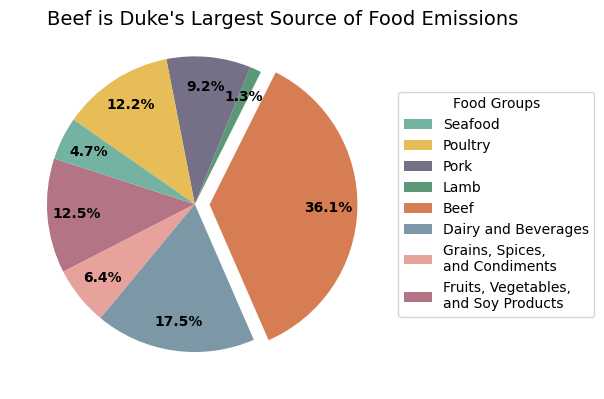

In [198]:
#@title Food Emissions Breakdown (Meat Groups)
pcts = [pc_fvs22, pc_gsc22, pc_db22, pc_beef22, pc_lamb22, pc_pork22, pc_poultry22, pc_seafood22]
labels = ['Fruits, Vegetables, \nand Soy Products', 'Grains, Spices, \nand Condiments', 'Dairy and Beverages', 'Beef', 'Lamb', 'Pork', 'Poultry', 'Seafood']

plt.pie(pcts,
        explode=[0, 0, 0, 0.1, 0, 0, 0, 0],
        pctdistance = .8,
        labeldistance = 1.3,
        autopct=lambda x: f'{x:.1f}%',
        textprops={"size": 10, "weight": 'bold'},
        radius = 1,
        colors = ["#b37486", "#e7a29c", "#7c98a6", "#d67d53", "#5b9877", "#757088", "#e6bd57", '#74b3a1'],
        startangle = 162
        )
plt.suptitle('Beef is Duke\'s Largest Source of Food Emissions',
             x = .65, y = .9, fontsize = 14, ha = 'center')
plt.legend(labels, loc="center right", bbox_to_anchor=(1.6, 0.5), title="Food Groups", reverse = True)

plt.show()

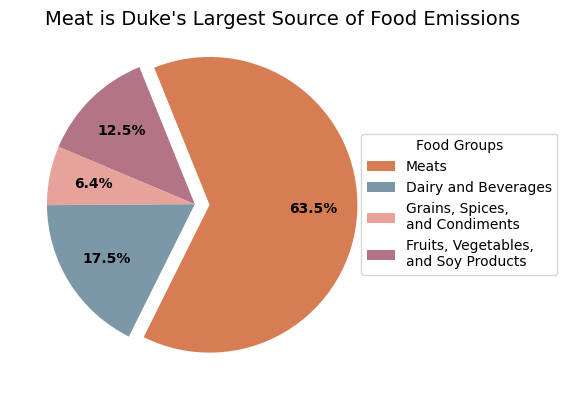

In [199]:
#@title Food Emissions Breakdown (Meat)
pcts = [pc_fvs22, pc_gsc22, pc_db22, pc_meat22]
labels = ['Fruits, Vegetables, \nand Soy Products', 'Grains, Spices, \nand Condiments', 'Dairy and Beverages', 'Meats']

plt.pie(pcts,
        explode=[0, 0, 0, 0.1],
        pctdistance = .7,
        labeldistance = 1.3,
        autopct=lambda x: f'{x:.1f}%',
        textprops={"size": 10, "weight": 'bold'},
        radius = 1,
        colors = ["#b37486", "#e7a29c", "#7c98a6", "#d67d53"],
        startangle = 112
        )
plt.suptitle('Meat is Duke\'s Largest Source of Food Emissions',
             x = .65, y = .9, fontsize = 14, ha = 'center')
plt.legend(labels, loc="center right", bbox_to_anchor=(1.5, 0.5), title="Food Groups", reverse = True)

plt.show()

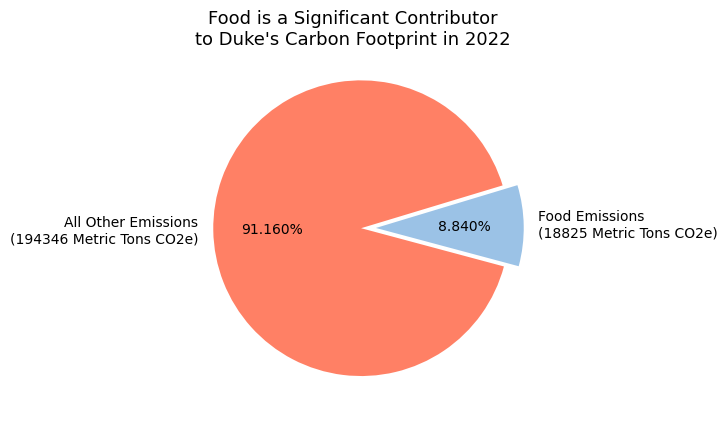

In [200]:
#@title Visualize Total Food Emissions
data = [8.84, 91.16]
explode = [0.1, 0]
keys = ['Food Emissions\n(18825 Metric Tons CO2e)', \
        'All Other Emissions\n(194346 Metric Tons CO2e)']

colors = ["#9BC2E6", "#FF8065"]

plt.pie(data, labels=keys, colors=colors, autopct='%.3f%%', \
        explode = explode, startangle = -15)
plt.suptitle('Food is a Significant Contributor\nto Duke\'s Carbon Footprint in 2022',
             y = .95, fontsize = 13)

plt.show()

Marketplace in 2022 was responsible for  2078.1281907164566 Megatons of CO2e
Duke Marine Lab in 2022 was responsible for  110.77674104303136 Megatons of CO2e
Freeman Center in 2022 was responsible for  60.517633208477065 Megatons of CO2e
Trinity Cafe in 2022 was responsible for  32.4651128382 Megatons of CO2e


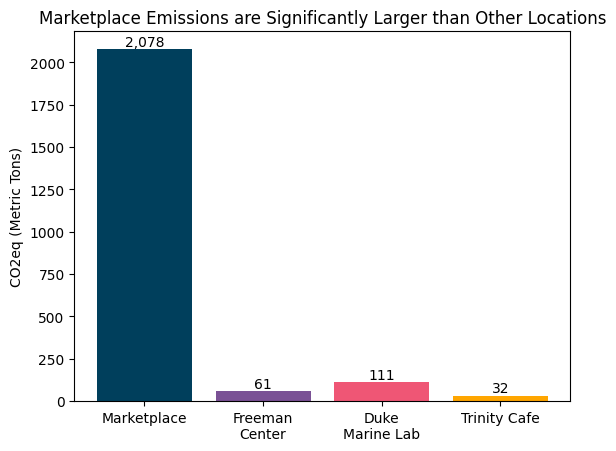

In [201]:
#@title Analyze Annual Emissions

marketplace_annual_co2_22 = np.sum(DDFY22[DDFY22['Unit Name'] == 'Marketplace']['CO2e(kg)']) / 1000
duml_annual_co2_22 = np.sum(DDFY22[DDFY22['Unit Name'] == 'DuML']['CO2e(kg)']) / 1000
freeman_annual_co2_22 = np.sum(DDFY22[DDFY22['Unit Name'] == 'Freeman']['CO2e(kg)']) / 1000
trinity_annual_co2_22 = np.sum(DDFY22[DDFY22['Unit Name'] == 'Trinity']['CO2e(kg)']) / 1000

print('Marketplace in 2022 was responsible for ', marketplace_annual_co2_22, 'Megatons of CO2e')
print('Duke Marine Lab in 2022 was responsible for ', duml_annual_co2_22, 'Megatons of CO2e')
print('Freeman Center in 2022 was responsible for ', freeman_annual_co2_22, 'Megatons of CO2e')
print('Trinity Cafe in 2022 was responsible for ', trinity_annual_co2_22, 'Megatons of CO2e')


counts = [marketplace_annual_co2_22, freeman_annual_co2_22, duml_annual_co2_22, trinity_annual_co2_22]
fig, ax = plt.subplots()
labels = ['Marketplace', 'Freeman\nCenter', 'Duke\nMarine Lab', 'Trinity Cafe']
bar_colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
bars = ax.bar(labels, counts, color = bar_colors)
ax.set_ylabel('CO2eq (Metric Tons)')
ax.set_title('Marketplace Emissions are Significantly Larger than Other Locations')
ax.bar_label(bars , fmt='{:,.0f}')
plt.show()

Fiscal Year
2020    1378.972406
2021    1255.294424
2022    2078.128191
2023    1955.847282
Name: CO2e(kg), dtype: float64


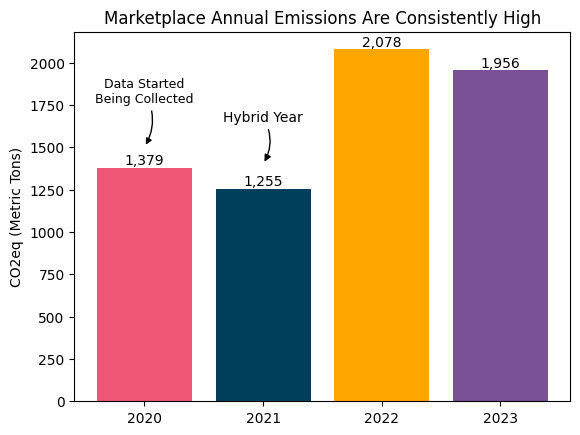

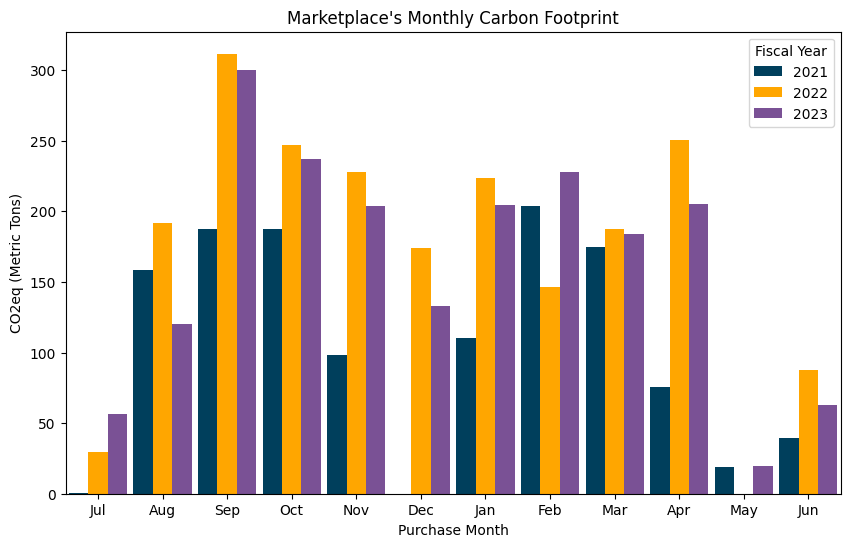

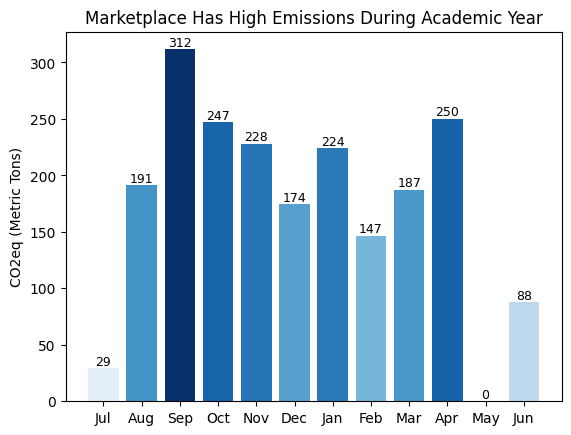

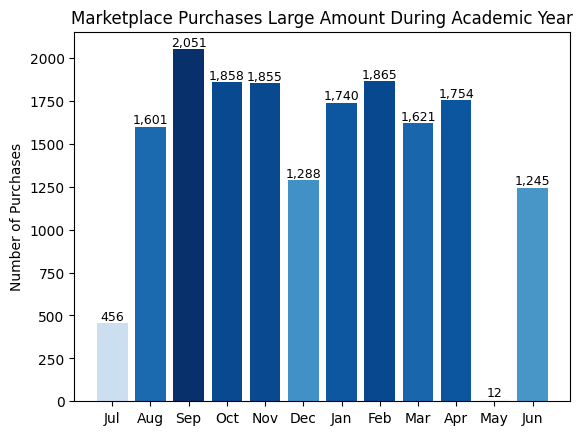

In [202]:
#@title Analyze Marketplace
#make marketplace dataframe
df_marketplace = pd.concat([DDFY20[DDFY20['Unit Name'] == 'Marketplace'],
                            DDFY21[DDFY21['Unit Name'] == 'Marketplace'],
                            DDFY22[DDFY22['Unit Name'] == 'Marketplace'],
                            DDFY23[DDFY23['Unit Name'] == 'Marketplace']], axis=0)

print((df_marketplace.groupby('Fiscal Year')['CO2e(kg)'].sum() / 1000)[0:4])

#Annual Emissions Visualization
fig_mp1, ax_mp1 = plt.subplots()
years_mp1 = (df_marketplace.groupby('Fiscal Year')['CO2e(kg)'].sum() / 1000).index
counts_mp1 = (df_marketplace.groupby('Fiscal Year')['CO2e(kg)'].sum() / 1000)
bar_colors = ['#ef5675', '#003f5c', '#ffa600', '#7a5195']
bars_mp1 = ax_mp1.bar(years_mp1, counts_mp1, color=bar_colors)
ax_mp1.set_ylabel('CO2eq (Metric Tons)')
ax_mp1.set_title('Marketplace Annual Emissions Are Consistently High')
ax_mp1.bar_label(bars_mp1 , fmt='{:,.0f}')
ax_mp1.annotate('Data Started\nBeing Collected', (0, 1500),
            xytext=(0.14, 0.8), textcoords='axes fraction',
            arrowprops=dict(arrowstyle = '-|>', facecolor = 'black',
                            connectionstyle="arc3,rad=-.3"),
            fontsize=9,
            horizontalalignment='center', verticalalignment='bottom')
ax_mp1.annotate('Hybrid Year', (1, 1400),
            xytext=(0.38, 0.75), textcoords='axes fraction',
            arrowprops=dict(arrowstyle = '-|>', facecolor = 'black',
                            connectionstyle="arc3,rad=-.3"),
            fontsize=10,
            horizontalalignment='center', verticalalignment='bottom')
plt.show()

#Monthly Emissions Visualization, all years
metrics = df_marketplace.groupby(['Fiscal Year', 'Purchase Month'])['CO2e(kg)'].sum() / 1000
purchase_months = np.roll(np.arange(1, 13), -6)
years_mp2 = df_marketplace['Fiscal Year'].unique()
template = pd.MultiIndex.from_product([years_mp2, purchase_months], names=['Fiscal Year', 'Purchase Month']).to_frame(index=False)
metrics_filled = pd.merge(template, metrics, on=['Fiscal Year', 'Purchase Month'], how='left').fillna(0)
metrics_filled = metrics_filled[metrics_filled['Fiscal Year'] != '2020']
color_map = {year: color for year, color in zip(years_mp2, bar_colors)}
year_gap = 0.3
bar_width = 1.2 / len(years_mp2)
bar_positions = np.arange(len(purchase_months))
fig2, ax2 = plt.subplots(figsize=(10, 6))
for i, year in enumerate(years_mp2):
    data = metrics_filled.loc[metrics_filled['Fiscal Year'] == year, 'CO2e(kg)']
    if len(data) == 0:
        continue
    year_offset = (i - len(years_mp2) / 2) * year_gap
    ax2.bar(bar_positions + year_offset, data, width=bar_width, color=color_map[year], label=year)
ax2.set_xlabel('Purchase Month')
ax2.set_ylabel('CO2eq (Metric Tons)')
ax2.set_title('Marketplace\'s Monthly Carbon Footprint')
ax2.legend(title='Fiscal Year')
plt.xlim(bar_positions[0] - 0.5, bar_positions[-1] + 0.5)
plt.xticks(bar_positions, purchase_months)
month_names = [calendar.month_abbr[month] for month in purchase_months]
plt.xticks(bar_positions, month_names)
plt.show()

#Monthly Emissions Visualization, 2022 only
fig_mp3, ax_mp3 = plt.subplots()
counts_mp3 = (df_marketplace[df_marketplace['Fiscal Year'] == '2022'].groupby('Purchase Month')['CO2e(kg)'].sum() / 1000)
bars_mp3 = ax_mp3.bar(purchase_months, counts_mp3, color=cm.Blues(counts_mp3 / counts_mp3.max()))  # Using the 'Reds' colormap
ax_mp3.set_ylabel('CO2eq (Metric Tons)')
ax_mp3.set_title('Marketplace Has High Emissions During Academic Year')
ax_mp3.bar_label(bars_mp3, fmt='{:,.0f}', fontsize=9)
month_names = [calendar.month_abbr[month] for month in purchase_months]
bar_positions = [pos + 1 for pos in range(len(purchase_months))]
plt.xticks(bar_positions, month_names)
plt.show()

#Monthly Purchases Visualization, 2022 only
fig_mp4, ax_mp4 = plt.subplots()
counts_mp4 = (df_marketplace[df_marketplace['Fiscal Year'] == '2022'].groupby('Purchase Month')['CO2e(kg)'].count())
bars_mp4 = ax_mp4.bar(purchase_months, counts_mp4, color=cm.Blues(counts_mp4 / counts_mp4.max()))  # Using the 'Reds' colormap
ax_mp4.set_ylabel('Number of Purchases')
ax_mp4.set_title('Marketplace Purchases Large Amount During Academic Year')
ax_mp4.bar_label(bars_mp4, fmt='{:,.0f}', fontsize=9)
month_names = [calendar.month_abbr[month] for month in purchase_months]
bar_positions = [pos + 1 for pos in range(len(purchase_months))]
plt.xticks(bar_positions, month_names)
plt.show()

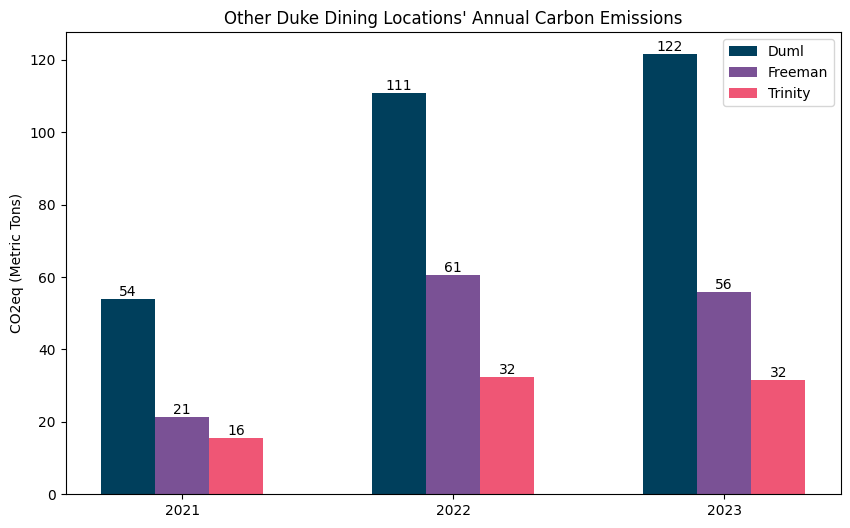

In [203]:
#@title Analyze DuML, Freeman, Trinity Annual
df_duml = pd.concat([DDFY20[DDFY20['Unit Name'] == 'DuML'],
                     DDFY21[DDFY21['Unit Name'] == 'DuML'],
                     DDFY22[DDFY22['Unit Name'] == 'DuML'],
                     DDFY23[DDFY23['Unit Name'] == 'DuML']], axis=0)
df_freeman = pd.concat([DDFY20[DDFY20['Unit Name'] == 'Freeman'],
                        DDFY21[DDFY21['Unit Name'] == 'Freeman'],
                        DDFY22[DDFY22['Unit Name'] == 'Freeman'],
                        DDFY23[DDFY23['Unit Name'] == 'Freeman']], axis=0)
df_trinity = pd.concat([DDFY20[DDFY20['Unit Name'] == 'Trinity'],
                        DDFY21[DDFY21['Unit Name'] == 'Trinity'],
                        DDFY22[DDFY22['Unit Name'] == 'Trinity'],
                        DDFY23[DDFY23['Unit Name'] == 'Trinity']], axis=0)

fig_other, ax_other = plt.subplots(figsize=(10, 6))

years_other = (df_duml.groupby('Fiscal Year')['CO2e(kg)'].sum() / 1000).index
counts_duml = (df_duml.groupby('Fiscal Year')['CO2e(kg)'].sum() / 1000)
counts_freeman = (df_freeman.groupby('Fiscal Year')['CO2e(kg)'].sum() / 1000)
counts_trinity = (df_trinity.groupby('Fiscal Year')['CO2e(kg)'].sum() / 1000)

bar_width = 0.2
bar_positions_duml = np.arange(len(years_other))
bar_positions_freeman = bar_positions_duml + bar_width
bar_positions_trinity = bar_positions_duml + 2 * bar_width
bar_colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
bars_duml = ax_other.bar(bar_positions_duml, counts_duml, width=bar_width, color=bar_colors[0], label='Duml')
bars_freeman = ax_other.bar(bar_positions_freeman, counts_freeman, width=bar_width, color=bar_colors[1], label='Freeman')
bars_trinity = ax_other.bar(bar_positions_trinity, counts_trinity, width=bar_width, color=bar_colors[2], label='Trinity')

ax_other.set_ylabel('CO2eq (Metric Tons)')
ax_other.set_title('Other Duke Dining Locations\' Annual Carbon Emissions')
ax_other.bar_label(bars_duml , fmt='{:,.0f}')
ax_other.bar_label(bars_freeman , fmt='{:,.0f}')
ax_other.bar_label(bars_trinity , fmt='{:,.0f}')
ax_other.set_xticks(bar_positions_duml + bar_width)
ax_other.set_xticklabels(years_other)

plt.legend()
plt.show()

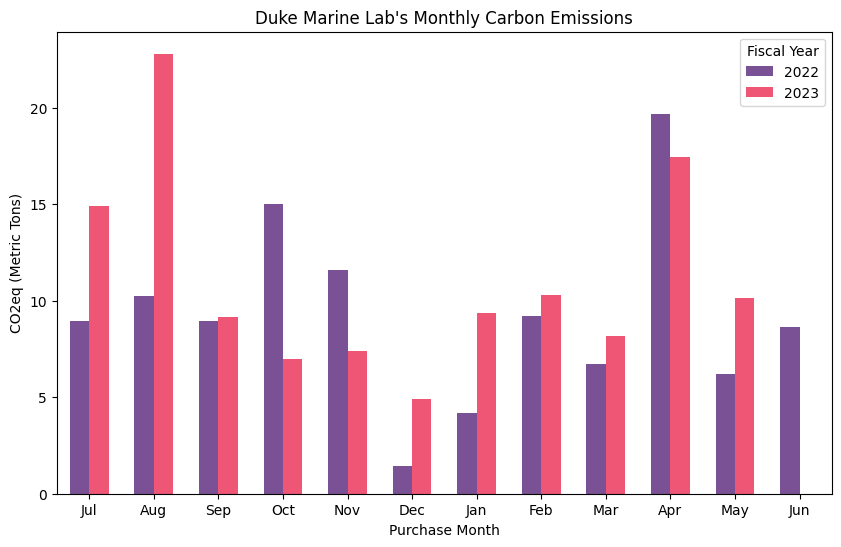

In [204]:
#@title DuML Location Monthly
metrics_duml = df_duml.groupby(['Fiscal Year', 'Purchase Month'])['CO2e(kg)'].sum() / 1000
years_duml = df_duml['Fiscal Year'].unique()
template = pd.MultiIndex.from_product([years_duml, purchase_months], names=['Fiscal Year', 'Purchase Month']).to_frame(index=False)
metrics_filled_duml = pd.merge(template, metrics_duml, on=['Fiscal Year', 'Purchase Month'], how='left').fillna(0)
metrics_filled_duml = metrics_filled_duml[(metrics_filled_duml['Fiscal Year'] != '2020') & (metrics_filled_duml['Fiscal Year'] != '2021')]
color_map = {year: color for year, color in zip(years_duml, bar_colors)}
year_gap = 0.3
bar_width = .9 / len(years_duml)
missing_bars = len(purchase_months) - len(metrics_filled_duml['Purchase Month'].unique())
bar_positions = np.arange(len(purchase_months) + missing_bars) + 1 * bar_width
fig_duml, ax_duml = plt.subplots(figsize=(10, 6))
for i, year in enumerate(years_duml):
    data = metrics_filled_duml.loc[metrics_filled_duml['Fiscal Year'] == year, 'CO2e(kg)']
    if len(data) == 0:
        continue
    year_offset = (i - len(years_duml) / 2) * year_gap
    ax_duml.bar(bar_positions + year_offset, data, width=bar_width, color=color_map[year], label=year)
ax_duml.set_xlabel('Purchase Month')
ax_duml.set_ylabel('CO2eq (Metric Tons)')
ax_duml.set_title('Duke Marine Lab\'s Monthly Carbon Emissions')
ax_duml.legend(title='Fiscal Year')
plt.xlim(bar_positions[0] - .5, bar_positions[-1] + .5)
plt.xticks(bar_positions, purchase_months)
month_names = [calendar.month_abbr[month] for month in purchase_months]
plt.xticks(bar_positions, month_names)
plt.show()

#4 peaks in 2023, more overall spending than in 2022
#2021 had too many empty months to consider relevant to the visualization

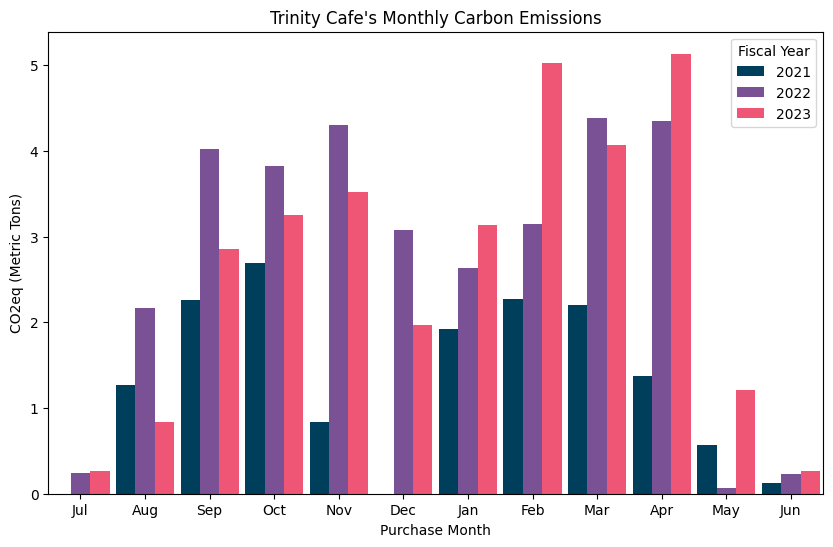

In [205]:
#@title Trinity Cafe Monthly
#shows negative bar
metrics_trinity = df_trinity.groupby(['Fiscal Year', 'Purchase Month'])['CO2e(kg)'].sum() / 1000
years_trinity = df_trinity['Fiscal Year'].unique()
template = pd.MultiIndex.from_product([years_trinity, purchase_months], names=['Fiscal Year', 'Purchase Month']).to_frame(index=False)
metrics_filled_trinity = pd.merge(template, metrics_trinity, on=['Fiscal Year', 'Purchase Month'], how='left').fillna(0)
metrics_filled_trinity = metrics_filled_trinity[metrics_filled_trinity['Fiscal Year'] != '2020']
color_map = {year: color for year, color in zip(years_trinity, bar_colors)}
year_gap = 0.3
bar_width = .9 / len(years_trinity)
missing_bars = len(purchase_months) - len(metrics_filled_trinity['Purchase Month'].unique())
bar_positions = np.arange(len(purchase_months) + missing_bars) + 1 * bar_width
fig_trinity, ax_trinity = plt.subplots(figsize=(10, 6))
for i, year in enumerate(years_trinity):
    data = metrics_filled_trinity.loc[metrics_filled_trinity['Fiscal Year'] == year, 'CO2e(kg)']
    if len(data) == 0:
        continue
    year_offset = (i - len(years_trinity) / 3) * year_gap
    ax_trinity.bar(bar_positions + year_offset, data, width=bar_width, color=color_map[year], label=year)
ax_trinity.set_xlabel('Purchase Month')
ax_trinity.set_ylabel('CO2eq (Metric Tons)')
ax_trinity.set_title('Trinity Cafe\'s Monthly Carbon Emissions')
ax_trinity.legend(title='Fiscal Year')
plt.xlim(bar_positions[0] - .5, bar_positions[-1] + .5)
plt.xticks(bar_positions, purchase_months)
month_names = [calendar.month_abbr[month] for month in purchase_months]
plt.xticks(bar_positions, month_names)
plt.show()

#more negative values, make visualization not great.
#second peak in spending doesn't make sense, why march?
#why so much lower in 2023? marketplace more reliable so less use of equivalency?
#consistently low in emisisons, with exceptions of the peaks

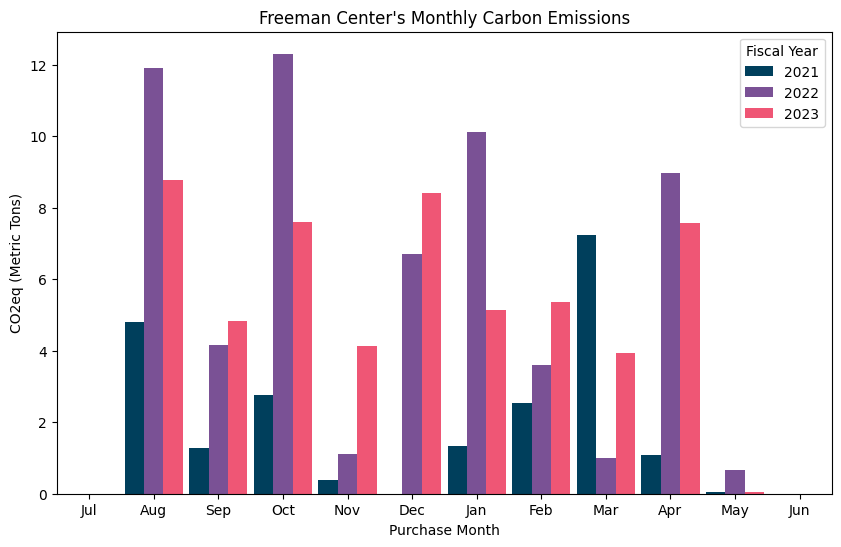

In [206]:
#@title Freeman Center Monthly
metrics_freeman = df_freeman.groupby(['Fiscal Year', 'Purchase Month'])['CO2e(kg)'].sum() / 1000
years_freeman = df_freeman['Fiscal Year'].unique()
template = pd.MultiIndex.from_product([years_freeman, purchase_months], names=['Fiscal Year', 'Purchase Month']).to_frame(index=False)
metrics_filled_freeman = pd.merge(template, metrics_freeman, on=['Fiscal Year', 'Purchase Month'], how='left').fillna(0)
metrics_filled_freeman = metrics_filled_freeman[metrics_filled_freeman['Fiscal Year'] != '2020']
color_map = {year: color for year, color in zip(years_freeman, bar_colors)}
year_gap = 0.3
bar_width = .9 / len(years_freeman)
missing_bars = len(purchase_months) - len(metrics_filled_freeman['Purchase Month'].unique())
bar_positions = np.arange(len(purchase_months) + missing_bars) + 1 * bar_width
fig_freeman, ax_freeman = plt.subplots(figsize=(10, 6))
for i, year in enumerate(years_freeman):
    data = metrics_filled_freeman.loc[metrics_filled_freeman['Fiscal Year'] == year, 'CO2e(kg)']
    if len(data) == 0:
        continue
    year_offset = (i - len(years_freeman) / 3) * year_gap
    ax_freeman.bar(bar_positions + year_offset, data, width=bar_width, color=color_map[year], label=year)
ax_freeman.set_xlabel('Purchase Month')
ax_freeman.set_ylabel('CO2eq (Metric Tons)')
ax_freeman.set_title('Freeman Center\'s Monthly Carbon Emissions')
ax_freeman.legend(title='Fiscal Year')
plt.xlim(bar_positions[0] - .5, bar_positions[-1] + .5)
month_names = [calendar.month_abbr[month] for month in purchase_months]
plt.xticks(bar_positions, month_names)
plt.show()

#no spending in summer months makes sense, not open
#peaks in August and April, not sure why April (maybe more Shabbat dinners or Senior Sendoff related)
#consistent spending throughout year, weekly Shabbat dinners?
#started consistently having emissions in FY2022 which is Post-Covid

In [207]:
#@title Average Daily Weight of Food Consumed @ Marketplace
num_days_mp22 = (max(df_marketplace[df_marketplace['Fiscal Year'] == '2022']['Purchase Date']) - min(df_marketplace[df_marketplace['Fiscal Year'] == '2022']['Purchase Date'])).days + 1
total_food_weight_mp22 = df_marketplace[df_marketplace['Fiscal Year'] == '2022']['Total Amount(kg)'].sum()
avg_kg_mp22 = total_food_weight_mp22 / num_days_mp22
print('The average daily weight of food consumed per day at Marketplace in FY22 is:', str.format('{0:.2f}', avg_kg_mp22), 'kg, or', str.format('{0:.2f}', avg_kg_mp22 * 2.2), 'lbs')
print('The total weight of food consumed per day at Marketplace in FY22 is:', str.format('{0:.2f}', total_food_weight_mp22), 'kg, or', str.format('{0:.2f}', total_food_weight_mp22 * 2.2), 'lbs')
print('')

num_days_duml22 = (max(df_duml[df_duml['Fiscal Year'] == '2022']['Purchase Date']) - min(df_duml[df_duml['Fiscal Year'] == '2022']['Purchase Date'])).days + 1
total_food_weight_duml22 = df_duml[df_duml['Fiscal Year'] == '2022']['Total Amount(kg)'].sum()
avg_kg_duml22 = total_food_weight_duml22 / num_days_duml22
print('The average daily weight of food consumed per day at Duke Marine Lab in FY22 is:', str.format('{0:.2f}', avg_kg_duml22), 'kg, or', str.format('{0:.2f}', avg_kg_duml22 * 2.2), 'lbs.')
print('The total weight of food consumed per day at Duke Marine Lab in FY22 is:', str.format('{0:.2f}', total_food_weight_duml22), 'kg, or', str.format('{0:.2f}', total_food_weight_duml22 * 2.2), 'lbs')
print('')

num_days_trinity22 = (max(df_trinity[df_trinity['Fiscal Year'] == '2022']['Purchase Date']) - min(df_trinity[df_trinity['Fiscal Year'] == '2022']['Purchase Date'])).days + 1
total_food_weight_trinity22 = df_trinity[df_trinity['Fiscal Year'] == '2022']['Total Amount(kg)'].sum()
avg_kg_trinity22 = total_food_weight_trinity22 / num_days_trinity22
print('The average daily weight of food consumed per day at Trinity Cafe in FY22 is:', str.format('{0:.2f}', avg_kg_trinity22), 'kg, or', str.format('{0:.2f}', avg_kg_trinity22 * 2.2), 'lbs.')
print('The total weight of food consumed per day at Trinity Cafe in FY22 is:', str.format('{0:.2f}', total_food_weight_trinity22), 'kg, or', str.format('{0:.2f}', total_food_weight_trinity22 * 2.2), 'lbs')
print('')

num_days_freeman22 = (max(df_freeman[df_freeman['Fiscal Year'] == '2022']['Purchase Date']) - min(df_freeman[df_freeman['Fiscal Year'] == '2022']['Purchase Date'])).days + 1
total_food_weight_freeman22 = df_freeman[df_freeman['Fiscal Year'] == '2022']['Total Amount(kg)'].sum()
avg_kg_freeman22 = total_food_weight_freeman22 / num_days_freeman22
print('The average daily weight of food consumed per day at Freeman Center in FY22 is:', str.format('{0:.2f}', avg_kg_freeman22), 'kg, or', str.format('{0:.2f}', avg_kg_freeman22 * 2.2), 'lbs.')
print('The total weight of food consumed per day at Freeman Center in FY22 is:', str.format('{0:.2f}', total_food_weight_freeman22), 'kg, or', str.format('{0:.2f}', total_food_weight_freeman22 * 2.2), 'lbs')
print('')

print('This is assuming all food purchased is consumed and that all food is consumed equally every day of the year.')
print('The average human eats 2kg or 4lbs a day.')
total_food_weight_22 = total_food_weight_mp22 + total_food_weight_duml22 + total_food_weight_trinity22 + total_food_weight_freeman22
print('The total weight in FY22 was', str.format('{0:.2f}', total_food_weight_22), 'kg or', str.format('{0:.2f}', total_food_weight_22 * 2.204), 'lbs')

The average daily weight of food consumed per day at Marketplace in FY22 is: 1237.81 kg, or 2723.17 lbs
The total weight of food consumed per day at Marketplace in FY22 is: 445610.34 kg, or 980342.76 lbs

The average daily weight of food consumed per day at Duke Marine Lab in FY22 is: 61.01 kg, or 134.22 lbs.
The total weight of food consumed per day at Duke Marine Lab in FY22 is: 22146.91 kg, or 48723.21 lbs

The average daily weight of food consumed per day at Trinity Cafe in FY22 is: 63.64 kg, or 140.00 lbs.
The total weight of food consumed per day at Trinity Cafe in FY22 is: 22463.86 kg, or 49420.50 lbs

The average daily weight of food consumed per day at Freeman Center in FY22 is: 42.88 kg, or 94.33 lbs.
The total weight of food consumed per day at Freeman Center in FY22 is: 12820.67 kg, or 28205.48 lbs

This is assuming all food purchased is consumed and that all food is consumed equally every day of the year.
The average human eats 2kg or 4lbs a day.
The total weight in FY22 w

In [208]:
#@title CO2 per pound, all locations
print('Marketplace: ', str.format('{0:.2f}', marketplace_annual_co2_22 * 1000 / total_food_weight_mp22), 'kg CO2eq/kg food on average')
print('DuML: ', str.format('{0:.2f}', duml_annual_co2_22 * 1000 / total_food_weight_duml22), 'kg CO2eq/kg food on average')
print('Trinity: ', str.format('{0:.2f}', trinity_annual_co2_22 * 1000 / total_food_weight_trinity22), 'kg CO2eq/kg food on average')
print('Freeman: ', str.format('{0:.2f}', freeman_annual_co2_22 * 1000 / total_food_weight_freeman22), 'kg CO2eq/kg food on average')

Marketplace:  4.66 kg CO2eq/kg food on average
DuML:  5.00 kg CO2eq/kg food on average
Trinity:  1.45 kg CO2eq/kg food on average
Freeman:  4.72 kg CO2eq/kg food on average


In [209]:
#DDFY22.to_csv('DD22Test.csv', encoding = 'utf-8-sig')
#files.download('DD22Test.csv')